In [1]:
!pip install requests pandas numpy python-dotenv scikit-learn matplotlib


In [2]:
# solar_forecast_project/main.py


import os
import requests
import zipfile
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Load .env from custom path
load_dotenv("/content/drive/MyDrive/Colab Notebooks/Solar Forecast/NREL_API.env")
API_KEY = os.getenv("API_KEY")
EMAIL = os.getenv("EMAIL")


In [20]:
# Download CSV data from NREL NSRDB API
import requests
import urllib.parse

def download_csv_data(lat, lon, year):
    base_url = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv"
    params = {
        "api_key": API_KEY,
        "email": EMAIL,
        "wkt": f"POINT({lon} {lat})",
        "names": str(year),
        "interval": "30",
        "leap_day": "false",
        "utc": "true",
        "attributes": "ghi,dni,dhi,air_temperature,wind_speed,relative_humidity"
    }

    print(f"Requesting solar data for lat={lat}, lon={lon}, year={year}...")

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        filename = "solar_data.csv"
        with open(filename, "wb") as f:
            f.write(response.content)
        print("CSV Download complete.")
        return filename  #RETURN FILENAME
    else:
        print(f"Failed to download CSV data: {response.status_code}\n{response.text}")
        raise Exception("Download failed")


def fill_missing_timestamps(df):
    # Create full datetime column from year, month, day, hour, minute
    df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df = df.set_index('datetime')

    # Create a complete datetime index from min to max datetime in 30-min intervals
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30min')

    # Reindex and fill missing rows with forward fill or zeros
    df = df.reindex(full_index)

    # Fill missing values by forward fill (or bfill if you prefer)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Reset index and rename datetime column
    df = df.reset_index().rename(columns={'index': 'datetime'})

    return df


In [21]:
# Load data into DataFrame
import pandas as pd

def load_data():
    df = pd.read_csv("nsrdb_data.csv", skiprows=2)  # skip the 2 header rows per NSRDB format

    # Check columns
    print("Columns in CSV:", df.columns.tolist())

    # Combine date-time columns
    df['Time'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

    # Select and rename columns to consistent names
    df = df.rename(columns={
        'Temperature': 'air_temperature',
        'Wind Speed': 'wind_speed',
        'Relative Humidity': 'relative_humidity',
        'GHI': 'ghi',
        'DNI': 'dni',
        'DHI': 'dhi'
    })
    # Sometimes columns are named differently - check for 'air_temperature' or 'Temperature'
    if 'air_temperature' in df.columns:
        df.rename(columns={'air_temperature': 'Air Temperature'}, inplace=True)
    elif 'Temperature' in df.columns:
        df.rename(columns={'Temperature': 'Air Temperature'}, inplace=True)

    # Keep only relevant columns
    needed_cols = ['Time', 'GHI', 'DNI', 'DHI', 'Air Temperature', 'Wind Speed', 'Relative Humidity']
    df = df[needed_cols]

    df = df.fillna(method='ffill')
    df.set_index('Time', inplace=True)
    return df
def load_data(filename):
    # Skip first two metadata rows
    df = pd.read_csv(filename, header=2)

    # Rename columns to standard names
    rename_dict = {
        'Temperature': 'air_temperature',
        'Wind Speed': 'wind_speed',
        'Relative Humidity': 'relative_humidity',
        'GHI': 'ghi',
        'DNI': 'dni',
        'DHI': 'dhi'
    }
    df.rename(columns=rename_dict, inplace=True)

    # Create a datetime index
    try:
        df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
        df.set_index('datetime', inplace=True)
        df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
    except KeyError:
        print("Could not find time columns in the dataset.")
        print("Available columns:", df.columns.tolist())
        raise

    # Fill missing values
    df = df.ffill()

    print("DataFrame loaded. Columns:", df.columns.tolist())
    return df



In [29]:
# Feature engineering and train/test split
def prepare_data(df):
    # Forecast 1 hour ahead (30-min interval means 2 steps per hour)
    df['GHI_next'] = df['ghi'].shift(-2)  # shift by 2 intervals for 1-hour forecast

    df = df.dropna()

    X = df.drop(columns='GHI_next')
    y = df['GHI_next']

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=200,max_depth=15, min_samples_leaf=3, random_state=42)
    model.fit(X_train, y_train)
    return model

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    plt.figure(figsize=(12, 5))
    plt.plot(y_test.values[:200], label="Actual")
    plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
    plt.title("GHI Forecast vs Actual")
    plt.xlabel("Sample")
    plt.ylabel("GHI")
    plt.legend()
    plt.show()


Requesting solar data for lat=41.5834, lon=-87.5, year=2020...
CSV Download complete.
Returned filename: solar_data.csv
DataFrame loaded. Columns: ['ghi', 'dni', 'dhi', 'air_temperature', 'wind_speed', 'relative_humidity']
Mean Absolute Error (MAE): 46.27


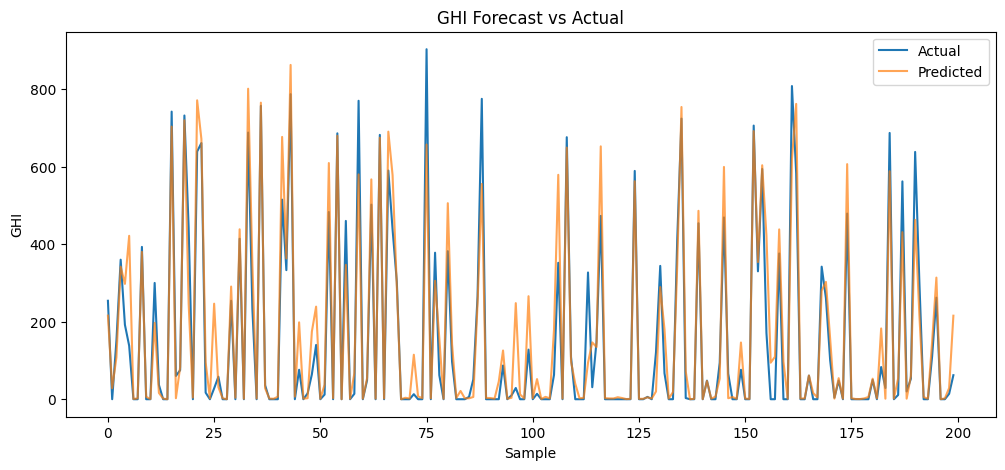

Forecasted GHI for 2020-11-05 11:00:00: 1.85


In [30]:
# Forecast for a specific datetime
def forecast_specific_datetime(model, df, target_datetime):
    try:
        sample = df.loc[target_datetime:target_datetime].drop(columns='GHI_next', errors='ignore')
        if sample.empty:
            print(f"No data available for {target_datetime}.")
            return
        prediction = model.predict(sample)[0]
        print(f"Forecasted GHI for {target_datetime}: {prediction:.2f}")
    except Exception as e:
        print(f"Error during prediction: {e}")

if __name__ == "__main__":
    # Example: Hammond, IN (41.5834, -87.5000)
    lat, lon = 41.5834, -87.5000
    year = 2020

    # Download CSV data from API
    # Download CSV data
    filename = download_csv_data(lat, lon, year)
    print("Returned filename:", filename)

    # Load and process the data using the returned filename
    df = load_data(filename)


    # Prepare training and testing data
    X_train, X_test, y_train, y_test = prepare_data(df)

    # Train the Random Forest model
    model = train_model(X_train, y_train)

    # Evaluate the model
    evaluate_model(model, X_test, y_test)

    # Forecast for a specific datetime
    specific_dt = datetime.strptime("2020-11-05 11:00", "%Y-%m-%d %H:%M")
    forecast_specific_datetime(model, df, specific_dt)